# Gradient Boosting Regression

Demonstrate Gradient Boosting on the Boston housing dataset.

This example fits a Gradient Boosting model with least squares loss and 500 regression trees of depth 4.

This is a port to OCaml of the [scikit-learn gradient boosting regression example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py).

In [1]:
#require "pyml"
#require "matplotlib"
#require "jupyter.notebook"
#require "shell"

/home/rlehy/.opam/4.07.1+flambda/lib/ocaml/unix.cma: loaded
/home/rlehy/.opam/4.07.1+flambda/lib/seq: added to search path
/home/rlehy/.opam/4.07.1+flambda/lib/result: added to search path
/home/rlehy/.opam/4.07.1+flambda/lib/result/result.cma: loaded
/home/rlehy/.opam/4.07.1+flambda/lib/uchar: added to search path
/home/rlehy/.opam/4.07.1+flambda/lib/stdcompat: added to search path
/home/rlehy/.opam/4.07.1+flambda/lib/stdcompat/stdcompat.cma: loaded
/home/rlehy/.opam/4.07.1+flambda/lib/pyml: added to search path
/home/rlehy/.opam/4.07.1+flambda/lib/pyml/pyml.cma: loaded
/home/rlehy/.opam/4.07.1+flambda/lib/pyml/numpy.cma: loaded
/home/rlehy/.opam/4.07.1+flambda/lib/base/caml: added to search path
/home/rlehy/.opam/4.07.1+flambda/lib/base/caml/caml.cma: loaded
/home/rlehy/.opam/4.07.1+flambda/lib/base/shadow_stdlib: added to search path
/home/rlehy/.opam/4.07.1+flambda/lib/base/shadow_stdlib/shadow_stdlib.cma: loaded
/home/rlehy/.opam/4.07.1+flambda/lib/sexplib0: added to search path
/

In [2]:
open Matplotlib;;
let plot () =
  let data = Mpl.plot_data `png in
  ignore (Jupyter_notebook.display ~base64:true "image/png" data);;

let () =
    Mpl.set_backend Agg
;;

val plot : unit -> unit = <fun>


In [3]:
(* load sklearn from the current git repo (build first with dune build @install) *)
let root = String.trim @@ Shell.run_full "git" ["rev-parse"; "--show-toplevel"];;
let libdir = root ^ "/_build/install/default/lib/sklearn/";;
Topdirs.dir_directory libdir;;
#load "sklearn.cma";;

val root : string = "/home/rlehy/projects/ocaml-sklearn2"


val libdir : string =
  "/home/rlehy/projects/ocaml-sklearn2/_build/install/default/lib/sklearn/"


- : unit = ()


In [4]:
(* it would be nice if the OCaml kernel installed printers automatically like utop *)
#install_printer Sklearn.Arr.pp;;
#install_printer Sklearn.Ndarray.pp;;
#install_printer Sklearn.Ensemble.GradientBoostingRegressor.pp;;

## Load data

In [5]:
(* The Python source does a custom split using shuffle(). The equivalent with train_test_split is simpler (see below) ,
   but it is nice to reproduce the numerical results and graphics. *)
   
(* (* the recommended simpler version *)
  let [@ocaml.warning "-8"] [x_train; x_test; y_train; y_test] =
  Sklearn.Model_selection.train_test_split [boston#data; boston#target] ~random_state:42 ~train_size:(`F 0.9);; *)

let boston = Sklearn.Datasets.load_boston();;

let [@ocaml.warning "-8"] [x; y] = Sklearn.Utils.shuffle [boston#data; boston#target] ~random_state:13;;
let offset = int_of_float @@ (float_of_int (Sklearn.Arr.shape x).(0)) *. 0.9;;
let x_train = Sklearn.Arr.(get_sub [slice ~j:offset ()] x);;
let y_train = Sklearn.Arr.(get_sub [slice ~j:offset ()] y);;
let x_test = Sklearn.Arr.(get_sub [slice ~i:offset ()] x);;
let y_test = Sklearn.Arr.(get_sub [slice ~i:offset ()] y);;

val boston :
  < data : Sklearn.Arr.t; descr : string; feature_names : Sklearn.Arr.t;
    filename : string; target : Sklearn.Arr.t > =
  <obj>


val x : Sklearn.Arr.t =
  [[1.50234e+01 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.49480e+02
  2.49100e+01]
 [5.44114e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.55290e+02
  1.77300e+01]
 [1.00245e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.80230e+02
  1.19800e+01]
 ...
 [7.89600e-02 0.00000e+00 1.28300e+01 ... 1.87000e+01 3.94920e+02
  6.78000e+00]
 [7.02200e-02 0.00000e+00 4.05000e+00 ... 1.66000e+01 3.93230e+02
  1.01100e+01]
 [3.30600e-02 0.00000e+00 5.19000e+00 ... 2.02000e+01 3.96140e+02
  8.51000e+00]]
val y : Sklearn.Arr.t =
  [12.  15.2 21.  24.  19.4 22.2 23.3 15.6 20.8 13.8 19.6 27.1 36.5 15.2
 11.7 14.1 17.2 16.8 32.9 21.4 32.4 23.5 20.4 13.1 12.6 10.4 50.  23.1
 13.4 24.3 25.   7.4  7.  22.  15.3  8.4 16.4 18.1 43.8  8.5 18.6 21.1
 50.  11.8 17.4 33.3 14.8  8.8 26.6 16.8 30.1 23.7 50.  19.5 16.1 24.1
 20.4 36.4 41.3 21.7 21.7 14.  21.7 20.4 20.  34.7 24.5 11.7 14.3 13.1
 17.4 20.1 19.5 21.  30.1 18.4 34.6 20.1 43.5 21.6 18.3 21.4 18.9 13.4
 30.8 25.  25.2  8.8 31.1 13.4

val offset : int = 455


val x_train : Sklearn.Arr.t =
  [[1.50234e+01 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.49480e+02
  2.49100e+01]
 [5.44114e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.55290e+02
  1.77300e+01]
 [1.00245e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.80230e+02
  1.19800e+01]
 ...
 [9.33889e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 6.07200e+01
  2.40800e+01]
 [2.22120e-01 0.00000e+00 1.00100e+01 ... 1.78000e+01 3.96900e+02
  1.70900e+01]
 [3.54800e-02 8.00000e+01 3.64000e+00 ... 1.64000e+01 3.95180e+02
  9.25000e+00]]


val y_train : Sklearn.Arr.t =
  [12.  15.2 21.  24.  19.4 22.2 23.3 15.6 20.8 13.8 19.6 27.1 36.5 15.2
 11.7 14.1 17.2 16.8 32.9 21.4 32.4 23.5 20.4 13.1 12.6 10.4 50.  23.1
 13.4 24.3 25.   7.4  7.  22.  15.3  8.4 16.4 18.1 43.8  8.5 18.6 21.1
 50.  11.8 17.4 33.3 14.8  8.8 26.6 16.8 30.1 23.7 50.  19.5 16.1 24.1
 20.4 36.4 41.3 21.7 21.7 14.  21.7 20.4 20.  34.7 24.5 11.7 14.3 13.1
 17.4 20.1 19.5 21.  30.1 18.4 34.6 20.1 43.5 21.6 18.3 21.4 18.9 13.4
 30.8 25.  25.2  8.8 31.1 13.4 48.3 17.8  5.6 12.7 16.1 20.9 19.9 13.9
 22.6 21.2 21.2 22.9 20.5 22.8 19.4 21.7 23.1 26.5 18.5 20.2 27.5 50.
 21.9 23.4 32.7 14.9 15.6 20.3 11.9 30.5 31.6 21.9 25.  23.  17.   7.2
 44.8 16.  38.7 20.4 22.5 21.7 12.7  5.  21.4 23.7 21.  19.5 20.1 24.6
 36.1 23.  18.5 32.5 19.1 23.3 18.5 21.5 19.3 26.4 31.  22.3 13.3  7.
 22.5 27.5 30.1 10.2 20.  25.  17.8 13.8 32.  23.7 23.8 16.7 23.8 18.8
 22.  29.  21.2 33.1 30.7 24.8 21.7 37.6 23.1 22.9 13.6 14.6 18.9 22.6
 31.7 19.4 12.7 20.1 30.3 18.8  8.1 20.6 33.2 2

val x_test : Sklearn.Arr.t =
  [[7.50260e-01 0.00000e+00 8.14000e+00 0.00000e+00 5.38000e-01 5.92400e+00
  9.41000e+01 4.39960e+00 4.00000e+00 3.07000e+02 2.10000e+01 3.94330e+02
  1.63000e+01]
 [5.47900e-02 3.30000e+01 2.18000e+00 0.00000e+00 4.72000e-01 6.61600e+00
  5.81000e+01 3.37000e+00 7.00000e+00 2.22000e+02 1.84000e+01 3.93360e+02
  8.93000e+00]
 [1.40520e-01 0.00000e+00 1.05900e+01 0.00000e+00 4.89000e-01 6.37500e+00
  3.23000e+01 3.94540e+00 4.00000e+00 2.77000e+02 1.86000e+01 3.85810e+02
  9.38000e+00]
 [3.04900e-02 5.50000e+01 3.78000e+00 0.00000e+00 4.84000e-01 6.87400e+00
  2.81000e+01 6.46540e+00 5.00000e+00 3.70000e+02 1.76000e+01 3.87970e+02
  4.61000e+00]
 [2.36482e+01 0.00000e+00 1.81000e+01 0.00000e+00 6.71000e-01 6.38000e+00
  9.62000e+01 1.38610e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.96900e+02
  2.36900e+01]
 [5.78000e-02 0.00000e+00 2.46000e+00 0.00000e+00 4.88000e-01 6.98000e+00
  5.84000e+01 2.82900e+00 3.00000e+00 1.93000e+02 1.78000e+01 3.96900e+02
  5.04

val y_test : Sklearn.Arr.t =
  [15.6 28.4 28.1 31.2 13.1 37.2 22.  11.5 13.8 39.8 28.5 15.2 23.8 19.4
 27.1 18.9 17.9 45.4 15.6 21.6 21.4 19.9 17.8 23.  15.4  8.3 27.  36.
 22.8 17.1 22.6 23.9 17.7 31.5  8.4 14.5 13.4 15.7 17.5 15.  21.8 18.4
 25.1 19.4 17.6 18.2 24.3 23.1 24.1 23.2 20.6]


## Fit regression model

In [6]:
let get_f = function `F x -> x | _ -> assert false;;

let n_estimators = 500;;

module Gbr = Sklearn.Ensemble.GradientBoostingRegressor;;
let clf =
  Gbr.(create ~n_estimators ~max_depth:4 ~min_samples_split:(`I 2) ~learning_rate:0.01 ~loss:`Ls()
       |> fit ~x:x_train ~y:y_train);;

let mse = Sklearn.Metrics.mean_squared_error ~y_true:y_test ~y_pred:(Gbr.predict clf ~x:x_test) () |> get_f in
Printf.printf "MSE: %.4f\n%!" mse;;

val get_f : [> `F of 'a ] -> 'a = <fun>


val n_estimators : int = 500


module Gbr = Sklearn.Ensemble.GradientBoostingRegressor


val clf : Gbr.t =
  GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


MSE: 6.6411


- : unit = ()


## Plot training deviance

val protect : (unit -> 'a) -> 'a = <fun>


val call_loss :
  y:Sklearn.Arr.t -> raw_predictions:Sklearn.Arr.t -> Py.Object.t -> float =
  <fun>


val set_yticks : Matplotlib__Fig_ax.Ax.t -> Sklearn.Arr.t -> unit = <fun>


val set_yticklabels : Matplotlib__Fig_ax.Ax.t -> Sklearn.Arr.t -> unit =
  <fun>


val barh : Matplotlib__Fig_ax.Ax.t -> Sklearn.Arr.t -> Sklearn.Arr.t -> unit =
  <fun>


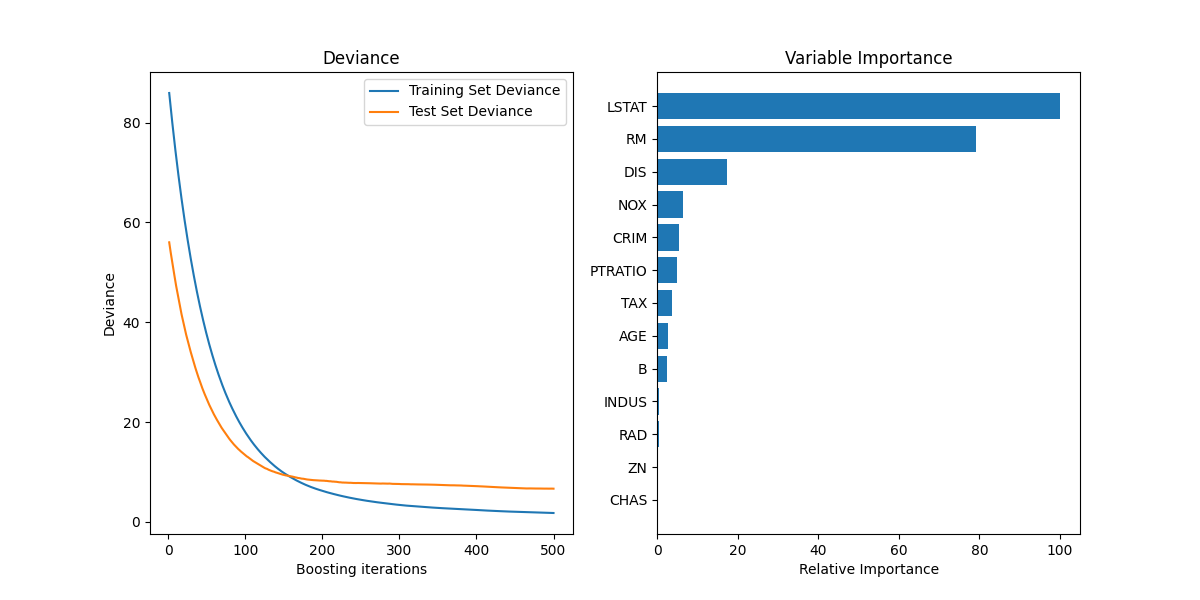

- : unit = ()


In [7]:
let protect f =
  try f()
  with (Py.E (a, b)) as exc -> Printf.printf "error: %s\n%s\n%!" (Py.Object.to_string a) (Py.Object.to_string b); raise exc

let call_loss ~y ~raw_predictions loss =
  Py.Callable.to_function loss [|Sklearn.Arr.to_pyobject y; Sklearn.Arr.to_pyobject raw_predictions|] |> Py.Float.to_float;;

(* TODO: contribute this to ocaml-matplotlib *)
let set_yticks ax ticks =
  let _ = Py.Module.get_function (Ax.Expert.to_pyobject ax) "set_yticks" [|Sklearn.Arr.to_pyobject ticks|] in ();;

let set_yticklabels ax labels =
  let _ = Py.Module.get_function (Ax.Expert.to_pyobject ax) "set_yticklabels" [|Sklearn.Arr.to_pyobject labels|] in ();;

(* Axes.barh(self, y, width, height=0.8, left=None, *, align='center', **kwargs)[source]) *)
let barh ax y width =
  let _ = Py.Module.get_function (Ax.Expert.to_pyobject ax) "barh" [|Sklearn.Arr.to_pyobject y; Sklearn.Arr.to_pyobject width|] in ();;

(* plot deviance *)
(* TODO: better wrapper for staged_predict (return iterator of Arr.t) *)
(* TODO: better wrapper for Gbr.loss_: return callable function *)
let test_score =
  let score = Sklearn.Ndarray.zeros ~dtype:(`S "float64") [n_estimators] in
  let _ = Py.Iter.fold_left
    (fun i e -> Sklearn.Ndarray.set [|`I i|] (`F (call_loss y_test (Sklearn.Arr.of_pyobject e) (Gbr.loss_ clf))) score; i+1)
    0 (Gbr.staged_predict clf ~x:x_test)
  in score
in

let fig, ax1, ax2 = Fig.create_with_two_axes ~figsize:(12., 6.) `horizontal in

let xs = Array.init n_estimators (fun i -> float_of_int (i+1)) in
let train_score = Gbr.train_score_ clf |> Sklearn.Arr.get_ndarray |> Sklearn.Ndarray.to_float_array in
Ax.set_title ax1 "Deviance";
Ax.plot ax1 ~label:"Training Set Deviance" ~linestyle:Solid ~xs train_score;
Ax.plot ax1 ~label:"Test Set Deviance" ~linestyle:Solid ~xs (Sklearn.Ndarray.to_float_array test_score);
Ax.legend ax1;
Ax.set_xlabel ax1 "Boosting iterations";
Ax.set_ylabel ax1 "Deviance";

(* TODO: rethink Ops (this should include min/max/argsort...?) *)
let feature_importance = Gbr.feature_importances_ clf in
let feature_importance = Sklearn.Arr.Ops.((int 100) * feature_importance / (float (Sklearn.Arr.max feature_importance))) in
let sorted_idx = Sklearn.Arr.argsort feature_importance in
let pos = Sklearn.Arr.arange (Sklearn.Arr.shape sorted_idx).(0) in
let pos = Sklearn.Arr.Ops.(pos + (float 0.5)) in
Ax.set_title ax2 "Variable Importance";
barh ax2 pos Sklearn.Arr.(get_sub [`Arr sorted_idx] feature_importance);
set_yticks ax2 pos;
set_yticklabels ax2 (Sklearn.Arr.get_sub [`Arr sorted_idx] boston#feature_names);
Ax.set_xlabel ax2 "Relative Importance";
Ax.set_title ax2 "Variable Importance";
plot ();;